In [10]:
!mkdir uci_bow
!mkdir uci_bow/train
!mkdir uci_bow/test
!mkdir multiwoz_batches

!git clone https://github.com/shoaib6174/MultiWOZ-Clustering/

!pip install bigartm10
!pip install kneed
!pip install pyclustering

Cloning into 'MultiWOZ-Clustering'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 37 (delta 20), reused 35 (delta 18), pack-reused 0
Unpacking objects: 100% (37/37), done.
     |████████████████████████████████| 2.0 MB 4.3 MB/s 
     |████████████████████████████████| 2.6 MB 4.1 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395122 sha256=0e7dad058bb0271a2240736cb80ff519d225cc7f5b5e383e2218ab031e5e8d85
  Stored in directory: /root/.cache/pip/wheels/ea/87/6b/1e0568b5ba9dc6518a25338bae90bd8392f35206bb90bb10f1
Successfully built pyclustering


In [11]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import matplotlib.pyplot as plt
import nltk
import string 
import artm

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

from pyclustering.utils import read_sample;
from pyclustering.cluster.dbscan import dbscan
from pyclustering.cluster.optics import optics, ordering_analyser, ordering_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer


## Utterance Representation 

I represented the utterances using tf-idf format. 

Steps: 



1.   Extracted the uttereances from json file of dialogues in a list(**utterances**) using **extract_texts()** function
2.   Cleaned the text using tokenization, lowercasing, punctuation and stop word removal, stripping, stemming and kept them in a list(**cleaned_texts**) using clean()  
3. In **get_tfidf()** function, used **sklearn.feature_extraction.text.TfidfVectorizer** to get the tf-idf of cleaned_texts.  **df** and **df_test** contains tf-idf of all the utterances of train and test folder of dialogues. So this df and df_test contains the tf-idf representation of the utterances.
4. BIGARTM takes input in UCI BOW/Vowpal Wabbit format only. So I saved the tf-idf data in UCI BOW format  ( **docword.multiwoz.txt**, **vocab.multiwoz.txt**) using **get_uci_bow()**. I saved the train and test data in different folders (uci_bow/train, uci_bow/test).





In [12]:
def extract_utterance(data):
    """
    Description: Returns a list of utterances from single json file
    Params: 
        data: json file of dialogue data
    """
    texts = []
    for item in data:
        for turn in item['turns']:

            text = turn['utterance']
            texts.append(text)
    return texts
def extract_texts(path):
    """
    Description: Returns a list of utterances extacted from folder of json file of dialogues

    Params:
      path: path of folder containing json file of dialogue data
    """   
    texts = []
    file_list = os.listdir(path)
    for file in file_list:
        with open(f'{path}/{file}') as f:
            data = json.load(f)
            texts += (extract_utterance(data))
    return texts
            


In [13]:
def clean(text):
  """
  Description: Returns cleaned text
  Params: 
    text: text to be cleaned
  """
  tokens = nltk.tokenize.word_tokenize(text)
  tokens = [w.lower() for w in tokens]
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  words = [word for word in stripped if word.isalpha()]
  words = [w for w in words if not w in stop_words]
  

  stemmed_words = [stemmer.stem(word) for word in words]
  sentence = " ".join(stemmed_words)
  return sentence

In [14]:
nltk.download("stopwords")
nltk.download('punkt')

stop_words = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Cleaning and TF-IDF


In [15]:
# extract utterances from json files 
def get_tfidf(path):
    """
    Description: Returns dataframe of all the files of specified folder in tf-idf format.
    """
    utterances = extract_texts(path)

    # clean the utterances
    cleaned_texts = []
    for utterance in utterances:
      cleaned_texts.append(clean(utterance))

    tfidf = TfidfVectorizer()

    response = tfidf.fit_transform(cleaned_texts)

    return pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())




*   For working with the whole dataset set **path="train"**
*   For experimenting with a smaller dataset set **path="sample"**




In [16]:
path="train"
df = get_tfidf(f"MultiWOZ-Clustering/{path}")
df_test = get_tfidf("MultiWOZ-Clustering/test")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# UCI Bag of Words Format

In [17]:
def get_uci_bow(dir, df):
  """
  Description: Writes the files in uci_bow/{dir} UCI BOW format from dataframe.
  """
  D = len(df.index)
  W = len(df.columns)
  C = np.count_nonzero(df)
  print(D, W, C)
  with open(f'uci_bow/{dir}/docword.multiwoz.txt', 'w') as docword:
    docword.write(f"{D}\n{W}\n{C}\n")
    for docID , row in df.iterrows():
      for wordID , val in enumerate(row):
        if val > 0:
          docword.write(f"{docID } {wordID+1 } {val}\n")


  with open(f'uci_bow/{dir}/vocab.multiwoz.txt', 'w') as vocab:
    for col in df.columns:
      vocab.write(f"{col}\n")

In [18]:
get_uci_bow("train", df)
get_uci_bow('test', df_test)

14744 1793 90157
10382 1611 62787


# Topic Modeling

I used artm model of BIGARTM for topic modeling. **topic_df** contains the topic informations (the utterances are in row wise and topics are in columns). I have also saved it in **topic_data.txt** file. 

In [19]:
batch_vectorizer = artm.BatchVectorizer(data_path='/content/uci_bow/train', data_format='bow_uci',
                                        collection_name='multiwoz', target_folder='multiwoz_batches')
batch_vectorizer_test = artm.BatchVectorizer(data_path='/content/uci_bow/test', data_format='bow_uci',
                                        collection_name='multiwoz', target_folder='multiwoz_batches')
                                        

### Perplexity Score

A lower perplexity score indicates better generalization performance.

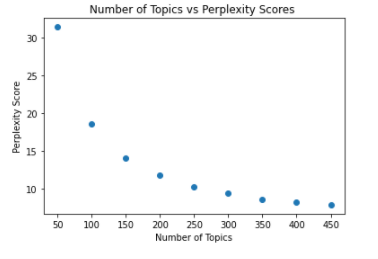

From the graph, I feel choosing num_topics = 250 will give a good fit.

In [20]:
# Choose parameters
num_topics = 250 
num_collection_passes = 10
scores= []
cache_theta  = True

model = artm.ARTM(num_topics=num_topics, dictionary=batch_vectorizer.dictionary, cache_theta = cache_theta ,
                  regularizers = [artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhiRegularizer')])

model.scores.add(artm.PerplexityScore(name='my_first_perplexity_score',
                                      dictionary=batch_vectorizer_test.dictionary))

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes= num_collection_passes)

model.score_tracker["my_first_perplexity_score"].value[-1]

# for the full dataset perplexity score is 10.41 for 250 topics

9.187456130981445

In [21]:
topic_df = model.get_theta().T

print(topic_df)

with open("topic_data.txt", 'w') as topic_data:
  for idx, row in topic_df.iterrows():
    for val in row:
      topic_data.write(f"{val} ")
    topic_data.write("\n")

       topic_0  topic_1   topic_2  ...  topic_247  topic_248     topic_249
9009   0.00000      0.0  0.000000  ...        0.0        0.0  0.000000e+00
9010   0.00000      0.0  0.000000  ...        0.0        0.0  0.000000e+00
9011   0.00000      0.0  0.377434  ...        0.0        0.0  0.000000e+00
9012   0.00000      0.0  0.000000  ...        0.0        0.0  0.000000e+00
9013   0.00000      0.0  0.000000  ...        0.0        0.0  6.989008e-07
...        ...      ...       ...  ...        ...        ...           ...
12016  0.00000      0.0  0.000000  ...        0.0        0.0  0.000000e+00
12017  0.00000      0.0  0.000000  ...        0.0        0.0  0.000000e+00
12018  0.45772      0.0  0.000000  ...        0.0        0.0  0.000000e+00
12019  0.00000      0.0  0.000000  ...        0.0        0.0  0.000000e+00
12020  0.00000      0.0  0.000000  ...        0.0        0.0  0.000000e+00

[14088 rows x 250 columns]


# Read Topic Data

In [22]:
data = read_sample("topic_data.txt")

In [23]:
def show_hist(clusters, title):
  """
  Description: Shows a histogram of count of items in each clusters, No oftotoal clusters and 
                total count of items in the clusters
  Params: 
    clusters: a list containing the lists of items of each clusters
    titile: Name of the algorithom
  """
  names = list(f"{i+1}" for i in range(len(clusters)) )
  values = list(len(c) for c in clusters)
  print(f"Total Cluster: {len(clusters)} \nTotal count of uttarance in Clusters:{sum(values)}")
  y_pos = np.arange(len(clusters))

  plt.figure(figsize=(20,10))
  plt.bar(y_pos, values, align='center', alpha=0.5)
  plt.xticks(y_pos, names)
  plt.ylabel('Count')
  plt.title(title)

  plt.show()

# Clustering

# I am using Colab and not being able to use the whole dataset because of resource constrains. I am getting runtime erro. **I have calculated  the parameters using the whole dataset but trained the model using a smaller dataset.**

# DBSCAN

### Elbow
I didn't get any good distribution of clusters using the elbow value.



NB: Following knee value is calculated using a smaller dataset of 14k utterances. For the whole dataset I got 0.33 to be the knee value. 

0.39470610133300993


<Figure size 360x360 with 0 Axes>

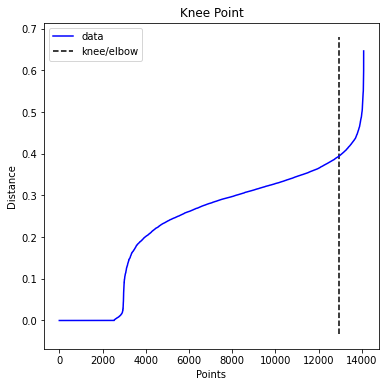

In [26]:
from kneed import KneeLocator

n_neighbors = 50
nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors = nearest_neighbors.fit(data)

distances, indices = neighbors.kneighbors(data)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

NB: Following model is trained on a smaller data set (around 14k utterences) and it classified around 5k utterences as outliers and around 8k utterances in one class. 

Total Cluster: 6 
Total count of uttarance in Clusters:8750


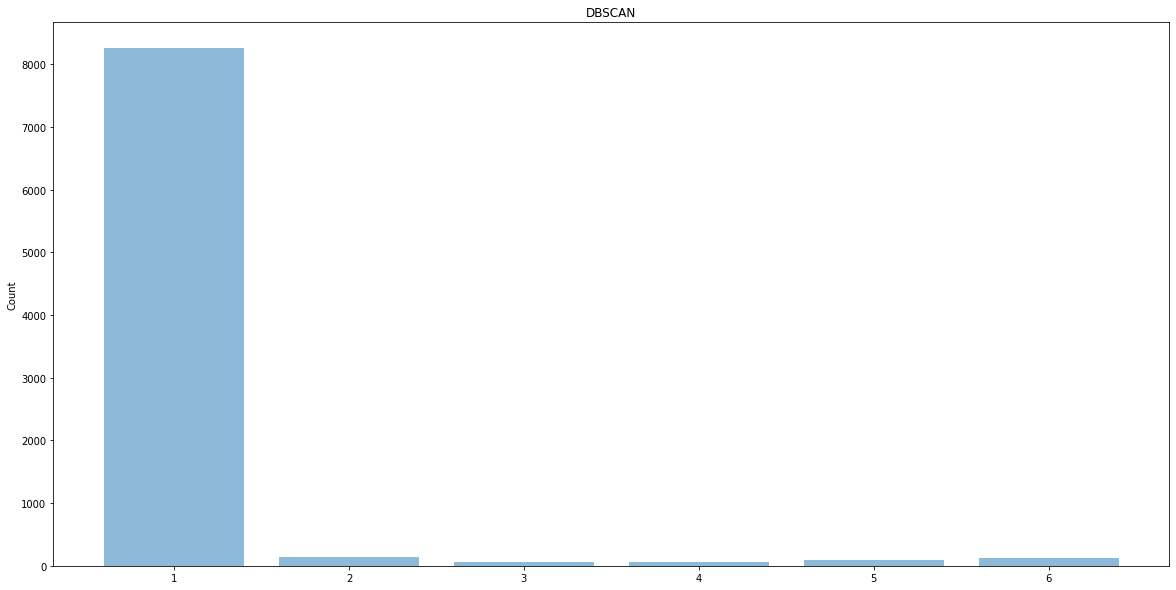

In [27]:
eps = 0.4
neighbors = 50

dbscan_instance = dbscan(data, eps, neighbors);
dbscan_instance.process();
clusters = dbscan_instance.get_clusters();

#histogram
show_hist(clusters, "DBSCAN")


# Optics

To find the optimum number of clusters I used Distortion and Silhouette Score Elbow for KMeans Clustering.  

Using values [100, 200, 300, 400, 500] I got elbow at 200 using Distortion Score. 
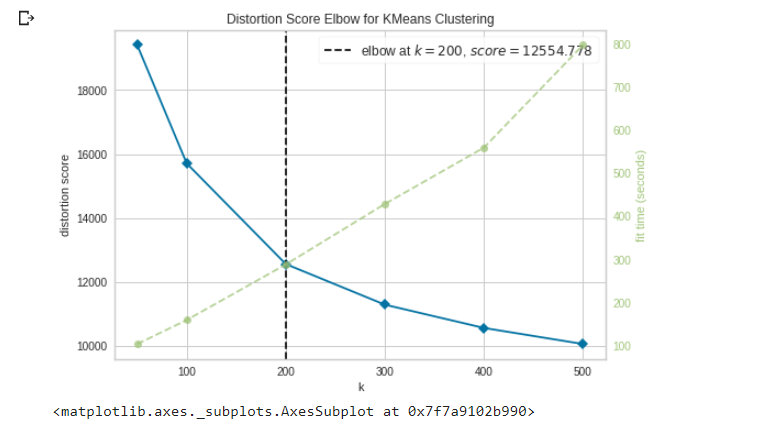


So then I tried using [50,75,100,125,150,175,200,225] and got elbow at 125 for distortion. 
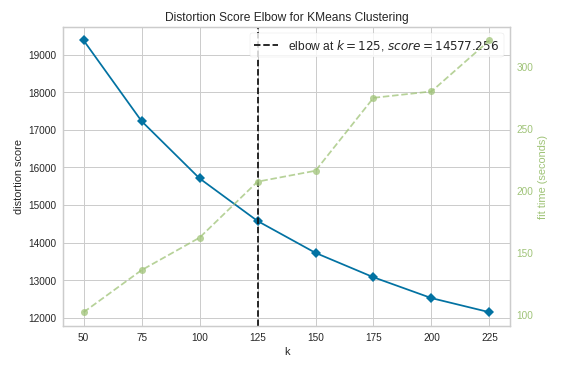

Then I used values [50,75,100,125,150,175,200,225] for Silhouette and got elbow at again at 125. 
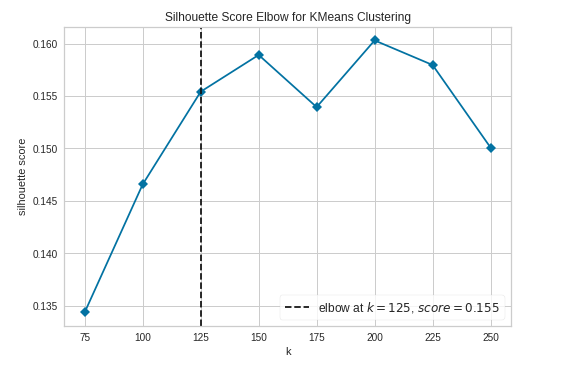


I have used amount_clusters to be 125 for optics and Xmeans



NB: Following model is trained on a smaller data set (around 14k utterences) and  it classified 10k utterences as outliers

Total Cluster: 66 
Total count of uttarance in Clusters:3904


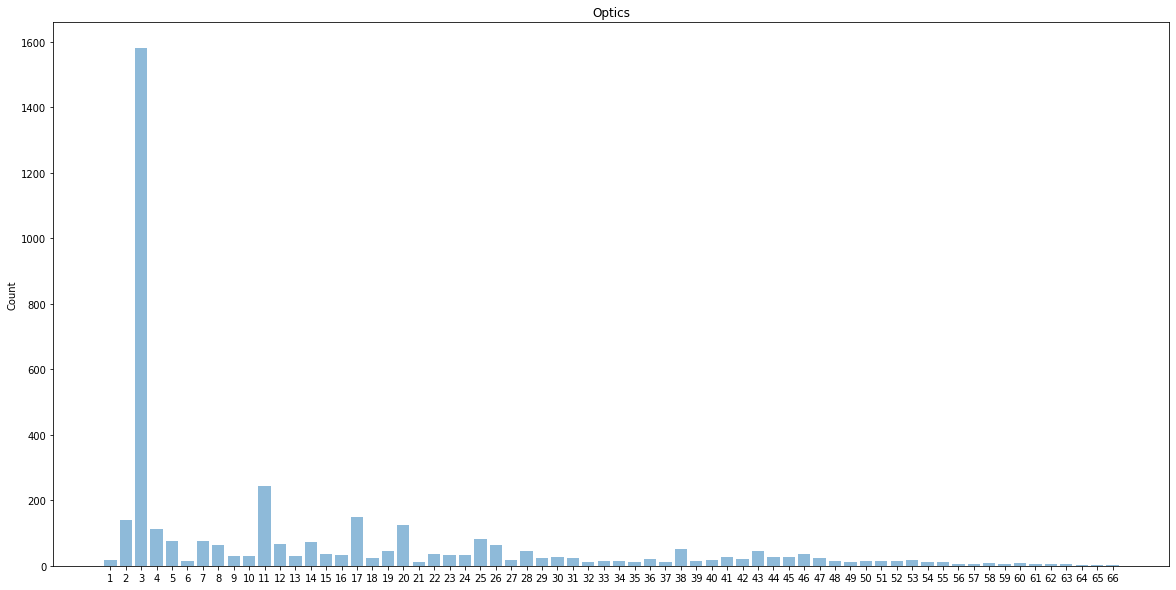

In [28]:
eps = 0.4
minpts= 10
amount_clusters = 125

optics_instance = optics(data,eps =eps, minpts = minpts, amount_clusters = amount_clusters)
optics_instance.process()
 
# Obtain results of clustering
clusters = optics_instance.get_clusters()

#histogram
show_hist(clusters, "Optics")


# XMEANS

NB: The following model is trained on the whole dataset (113k utterences)

Total WCE: 17326.49156344087
Total Cluster: 125 
Total count of uttarance in Clusters:113137


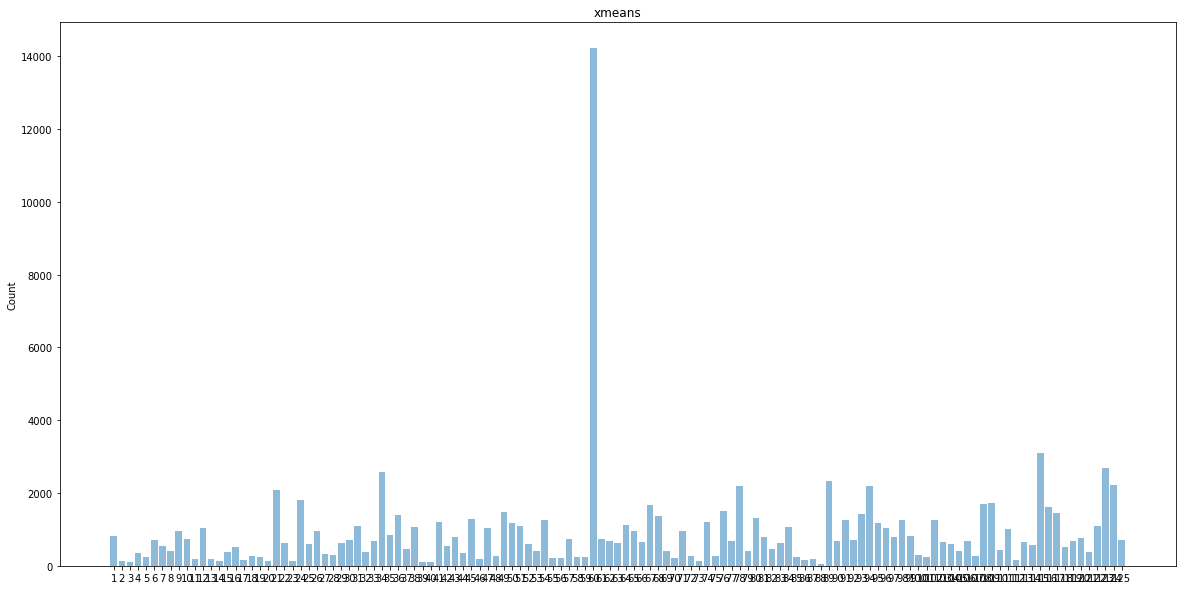

In [ ]:
amount_initial_centers = 30
number_of_clusters = 125
initial_centers = kmeans_plusplus_initializer(data, amount_initial_centers).initialize()
 
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is number_of_clusters.
xmeans_instance = xmeans(data, initial_centers, number_of_clusters)
xmeans_instance.process()
 
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
 
# Print total sum of metric errors
print("Total WCE:", xmeans_instance.get_total_wce())
 
#histogram
show_hist(clusters, "xmeans")